# Project Exploration and Writeup

## Histogram of Oriented Gradients (HOG)

In [3]:
from vehicle_detection_utils import *
import numpy as np
import glob
import cv2
import matplotlib.pyplot as plt
%matplotlib inline
%load_ext autoreload 
%autoreload 2

### Gather input data

In [4]:
vehicle_test_images = glob.glob("../project_data/vehicles/*/*.png")
nonvehicle_test_images = glob.glob("../project_data/non-vehicles/*/*.png")

In [5]:
print("Vehicle Images Size: %d" % len(vehicle_test_images))
print("Non-Vehicle Images Size: %d" % len(nonvehicle_test_images))

Vehicle Images Size: 8792
Non-Vehicle Images Size: 8968


HOG features are extracted by the functions **get_hog_features** and **extract_hog_features_from_img_list** used for different purposes at training time and inference time. These functions are located in the **vehicle_detection_utils.py** <br>
I started with the configuration from the lectures and started to vary the parameters to see if we have a more unique hog patterns for both positive and negative images.<br>



In [6]:
car_imgs = []
non_car_imgs = []
random_index = 0
num_images = 5
# read raw image data and normalize it 
for i in range(random_index, random_index+num_images):
    car_imgs.append(cv2.imread(vehicle_test_images[i]))
    non_car_imgs.append(cv2.imread(nonvehicle_test_images[i]))    

#### EXPLORE HOG PARAMETERS

In [27]:
def extract_hog_imgs(img_list, cspace='BGR2YCrCb', orient=9, pix_per_cell=8, cell_per_block=2):
    """
        Helper to extract hog features from an img list 
    """
    hog_feature_list = []
    for img in img_list:
        outputs = []
        copy_img = np.copy(img)
        copy_img = convert_color(np.copy(img), conv=cspace)
        copy_img = np.float32(img) / 255.0
        features, hog_images = get_hog_features(copy_img, orient, pix_per_cell, cell_per_block, vis=True, feature_vec=True, hog_channel=3)
        outputs.append(img)
        outputs.extend(hog_images)
        hog_feature_list.append(outputs)
    return hog_feature_list


def plot_features(feature_list):
    plt.figure(figsize=(10, 10))
    nrows = len(feature_list)
    for i in range(len(feature_list)):
        for j in range(1, 5):
            plt.subplot(nrows, 4, i*4+j)
            plt.imshow(feature_list[i][j-1], cmap='gray')

### HOG FEATURES WITH YCrCb

In [20]:
## TRY OUT SOME FEATURES AND COMPARES
orient = 9
pix_per_cell = 8
cell_per_block = 2
cspace = 'BGR2YCrCb'
# DEFAULT
test_car_hog_1 = extract_hog_imgs(car_imgs)
test_non_car_hog_1 = extract_hog_imgs(non_car_imgs)

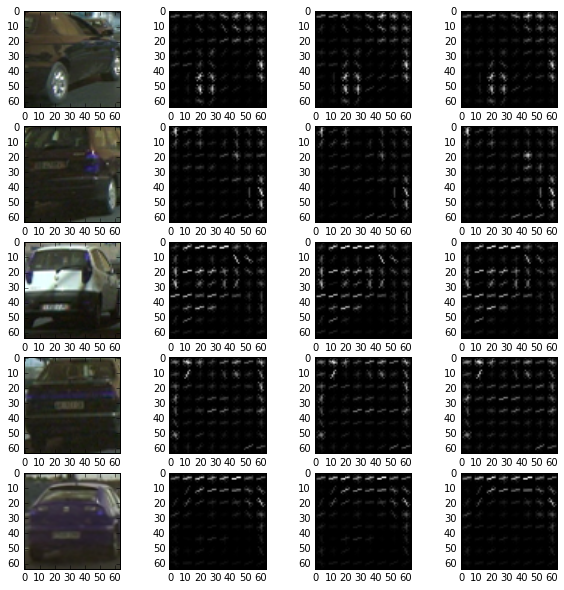

In [29]:
plot_features(test_car_hog_1)

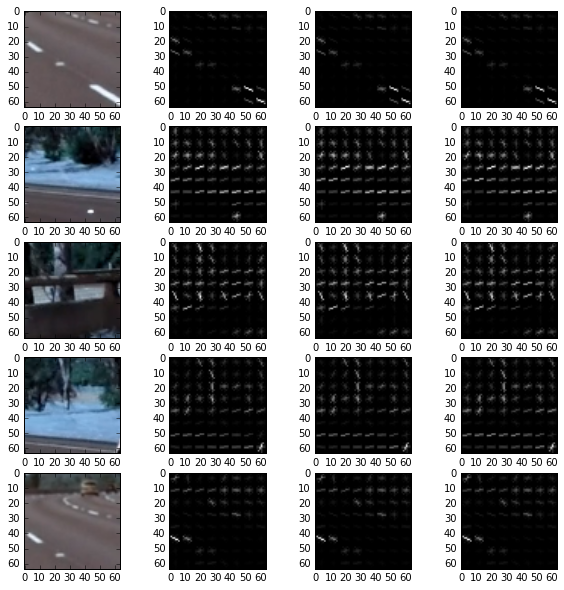

In [30]:
plot_features(test_non_car_hog_1)

In [34]:
## TRY DIFFERENT PARAMETERS
## TRY OUT SOME FEATURES AND COMPARES
orient = 12
pix_per_cell = 16
cell_per_block = 2
cspace = 'BGR2YCrCb'
# DEFAULT
test_car_hog_2 = extract_hog_imgs(car_imgs)
test_non_car_hog_2 = extract_hog_imgs(non_car_imgs)

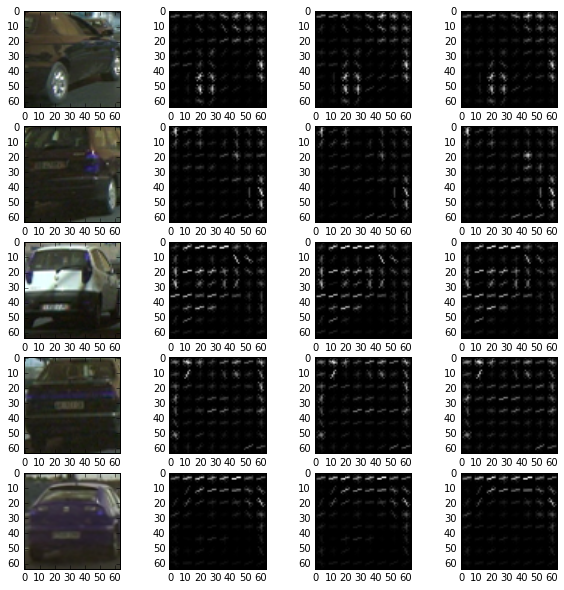

In [31]:
plot_features(test_car_hog_2)

NONCAR HOG FEATURES
CAR HOG FEATURES


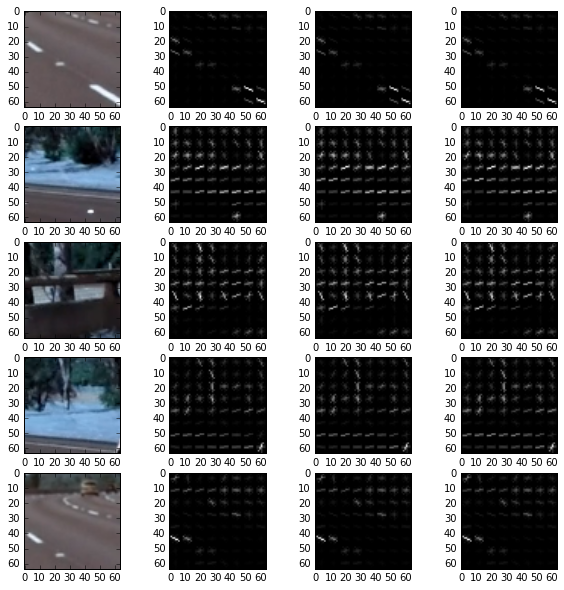

In [26]:
# NONCAR HOG FEATURES
print ("NONCAR HOG FEATURES")
plot_features(test_non_car_hog_2)

### HOG FEATURES WITH HLS

In [37]:
orient = 9
pix_per_cell = 8
cell_per_block = 2
cspace = 'BGR2HLS'

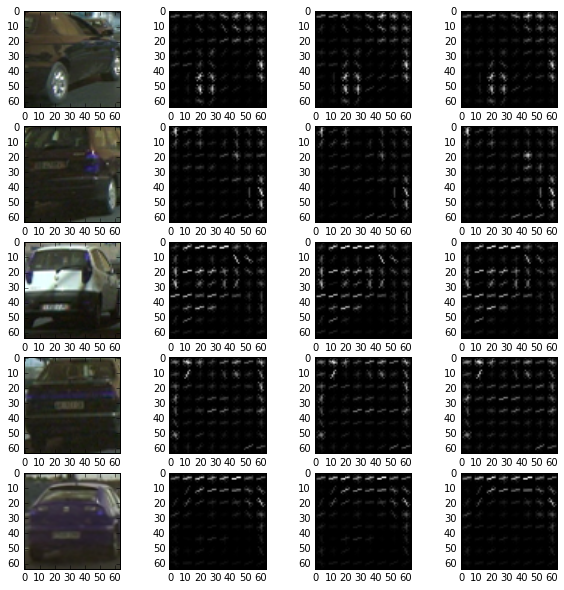

In [38]:
test_car_hog_2 = extract_hog_imgs(car_imgs)
test_non_car_hog_2 = extract_hog_imgs(non_car_imgs)
plot_features(test_car_hog_1)

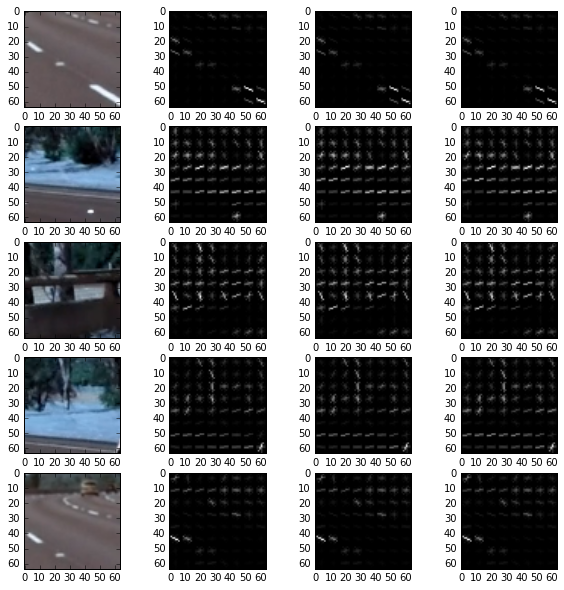

In [39]:
test_non_car_hog_2 = extract_hog_imgs(non_car_imgs)
plot_features(test_non_car_hog_1)

We can see the hog images of the car pictures has unique patterns at specific locations the reflects the shape of the car while the non-car images are all random pattern. Both color spaces show distinguish hog features between car and non-car, therefore, I decided to time how fast it take to extract hog features to decide which color spaces to use for extracting hog features because this is the major time consuming part of the pipeline. Also, I decided to keep the orient at 9 and evaluate the performance first before increase the orient values which might affect performance of the pipeline

In [45]:
import time
def profile_extract_time(img_list, cspace=cspace):
    t1 = time.time()
    extract_hog_imgs(img_list, cspace=cspace)
    t2 = time.time()
    print ("Total time for extracting all hog images for %s is %.2f " % (cspace, t2-t1))

In [50]:
car_imgs = []
non_car_imgs = []
random_index = 0
num_images = 1000
# read raw image data and normalize it 
for i in range(random_index, random_index+num_images):
    car_imgs.append(cv2.imread(vehicle_test_images[i]))
    non_car_imgs.append(cv2.imread(nonvehicle_test_images[i]))    

In [51]:
profile_extract_time(np.concatenate((car_imgs, non_car_imgs), axis=0), cspace="BGR2HLS")
profile_extract_time(np.concatenate((car_imgs, non_car_imgs), axis=0), cspace="BGR2YCrCb")
profile_extract_time(np.concatenate((car_imgs, non_car_imgs), axis=0), cspace="BGR2LUV")
profile_extract_time(np.concatenate((car_imgs, non_car_imgs), axis=0), cspace="BGR2YUV")

Total time for extracting all hog images for BGR2HLS is 135.25 
Total time for extracting all hog images for BGR2YCrCb is 136.06 
Total time for extracting all hog images for BGR2LUV is 144.65 
Total time for extracting all hog images for BGR2YUV is 180.60 


Based on the above result, I select YCrCb as the color space while HLS might also be a good options to try if the performance of YCrCb is not too good.

## TRAIN CLASSIFIER 

In [53]:
from sklearn.model_selection import train_test_split
import glob

### EXTRACT ALL IMAGE FEATURES

In [54]:
vehicle_files = glob.glob('../project_data/vehicles/*/*.png')
nonvehicle_files = glob.glob('../project_data/non-vehicles/*/*.png')
print("Number of car images %d" % len(vehicle_files))
print("Number of non-car images %d" % len(nonvehicle_files))

Number of car images 8792
Number of non-car images 8968


The data set for positive and negative cases looks balance here.

In [55]:
# extract hog and color features
vehicle_features = extract_featurres_from_img_list(vehicle_files)
nonvehicle_features = extract_featurres_from_img_list(nonvehicle_files)
nonvehicle_labels = np.zeros(len(nonvehicle_features))
# created labels
vehicle_labels = np.ones(len(vehicle_features))
labels = np.hstack((vehicle_labels, nonvehicle_labels))
# stack dataset
X = np.vstack((vehicle_features, nonvehicle_features)).astype(np.float64)
X = X.squeeze()
print ("X shape: %s" % X.shape)
print ("Y(labels) shape: %s" % labels.shape)

TypeError: not all arguments converted during string formatting